# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import string
import seaborn as sns
import warnings
from collections import defaultdict, Counter
import re



nltk.download('stopwords')
from nltk.corpus import stopwords
stopwords = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# Load Data

In [5]:
train_df = pd.read_csv("Disaster Tweets\train.csv")

In [6]:
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [7]:
print ("No. of rows in train dataset =", train_df.shape[0])

No. of rows in train dataset = 7613


In [8]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


# EDA

### Disaster vs Not Disaster

In [9]:
disaster= len(train_df[train_df['target'] ==1])
not_disaster= len(train_df[train_df['target'] ==0])
disaster_percent = disaster/(not_disaster+disaster)*100
not_disaster_percent = not_disaster/(not_disaster+disaster)*100

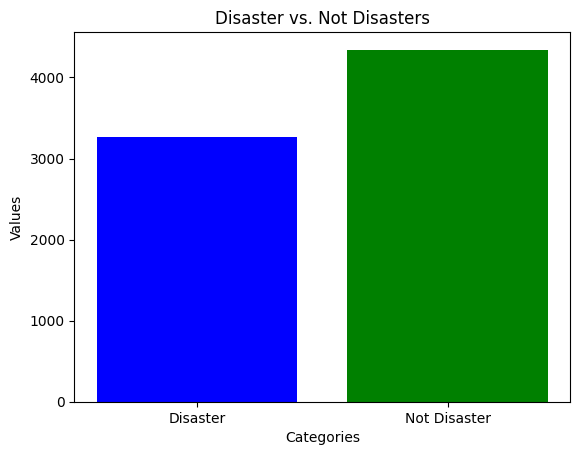

In [10]:
plt.bar(('Disaster', 'Not Disaster'), (disaster,not_disaster), color=['blue', 'green'])

plt.title('Disaster vs. Not Disasters')
plt.xlabel('Categories')
plt.ylabel('Values')

plt.show()

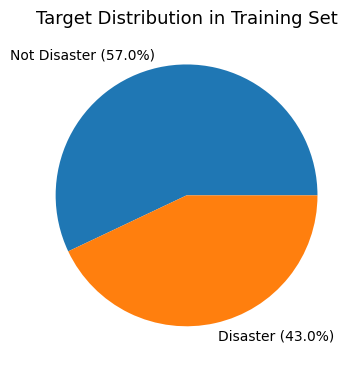

In [11]:
fig, axes = plt.subplots(ncols=1, figsize=(4, 4), dpi=100)

plt.tight_layout()
labels = [f'Not Disaster ({not_disaster_percent:.1f}%)', f'Disaster ({disaster_percent:.1f}%)']
train_df.groupby('target').count()['id'].plot(kind='pie', ax=axes, labels=labels)

axes.set_ylabel('')
axes.tick_params(axis='x', labelsize=15)
axes.tick_params(axis='y', labelsize=15)

axes.set_title('Target Distribution in Training Set', fontsize=13)

plt.show()

### NaN Values

In [12]:
print ("Percentage of NaN in df['keyword'] = ", train_df['keyword'].isna().sum()/len(train_df)*100)
print ("Percentage of NaN in df['location'] = ", train_df['location'].isna().sum()/len(train_df)*100)
print ("Percentage of NaN in df['text'] = ", train_df['text'].isna().sum()/len(train_df)*100)

print ("Unique Keyword values", len(train_df['keyword'].unique()))
print ("Unique Location values",len(train_df['location'].unique()))

Percentage of NaN in df['keyword'] =  0.8012610009194797
Percentage of NaN in df['location'] =  33.27203467752528
Percentage of NaN in df['text'] =  0.0
Unique Keyword values 222
Unique Location values 3342


location is very dirty and there are too many unique values in it. It shouldn't be used as a feature.

In [14]:
print ("Average Length of Disaster Tweets =", sum([len(i) for i in list(train_df[train_df['target']==1]['text'])])/len(train_df))
print ("Average Length of Non Disaster Tweets =", sum([len(i) for i in list(train_df[train_df['target']==0]['text'])])/len(train_df) )

Average Length of Disaster Tweets = 46.45199001707606
Average Length of Non Disaster Tweets = 54.585445947721006



### Meta Features
Distributions of meta features in classes and datasets can be helpful to identify disaster tweets.The meta features used for the analysis are;

* $word\_count$ number of words in text
* $unique\_word\_count$ number of unique words in text
* $stop\_word\_count$ number of stop words in text
* $url\_count$ number of urls in text
* $mean\_word\_length$ average character count in words
* $char\_count$ number of characters in text
* $punctuation\_count$ number of punctuations in text
* $hashtag\_count$ number of hashtags (#) in text
* $mention\_count$ number of mentions (@) in text

In [15]:
# word_count
train_df['word_count'] = train_df['text'].apply(lambda x : len(str(x).split()))

# unique_word
train_df['unique_word_count'] = train_df['text'].apply(lambda x : len(set(str(x).split())))

# stop_word_count
train_df['stop_word_count'] = train_df['text'].apply(lambda x : len([i for i in str(x).lower().split() if i in stopwords]))

# url_count_number
train_df['url_count'] = train_df['text'].apply(lambda x : len([i for i in str(x).split() if ('http' not in i or 'https' not in i)]))

# mean_word_length
train_df['mean_word_length'] = train_df['text'].apply(lambda x: np.mean([len(i) for i in str(x).split()]))

# char_count
train_df['char_count'] = train_df['text'].apply(lambda x: sum([len(i) for i in str(x).split()]))

# punctuation_count
train_df['punctuation_count'] = train_df['text'].apply(lambda x : len([i for i in str(x) if i in string.punctuation]))

# hashtag_count
train_df['hashtag_count'] = train_df['text'].apply(lambda x : len([i for i in str(x) if i=='#']))

# mention_count
train_df['mention_count'] = train_df['text'].apply(lambda x : len([i for i in str(x) if i=='@']))

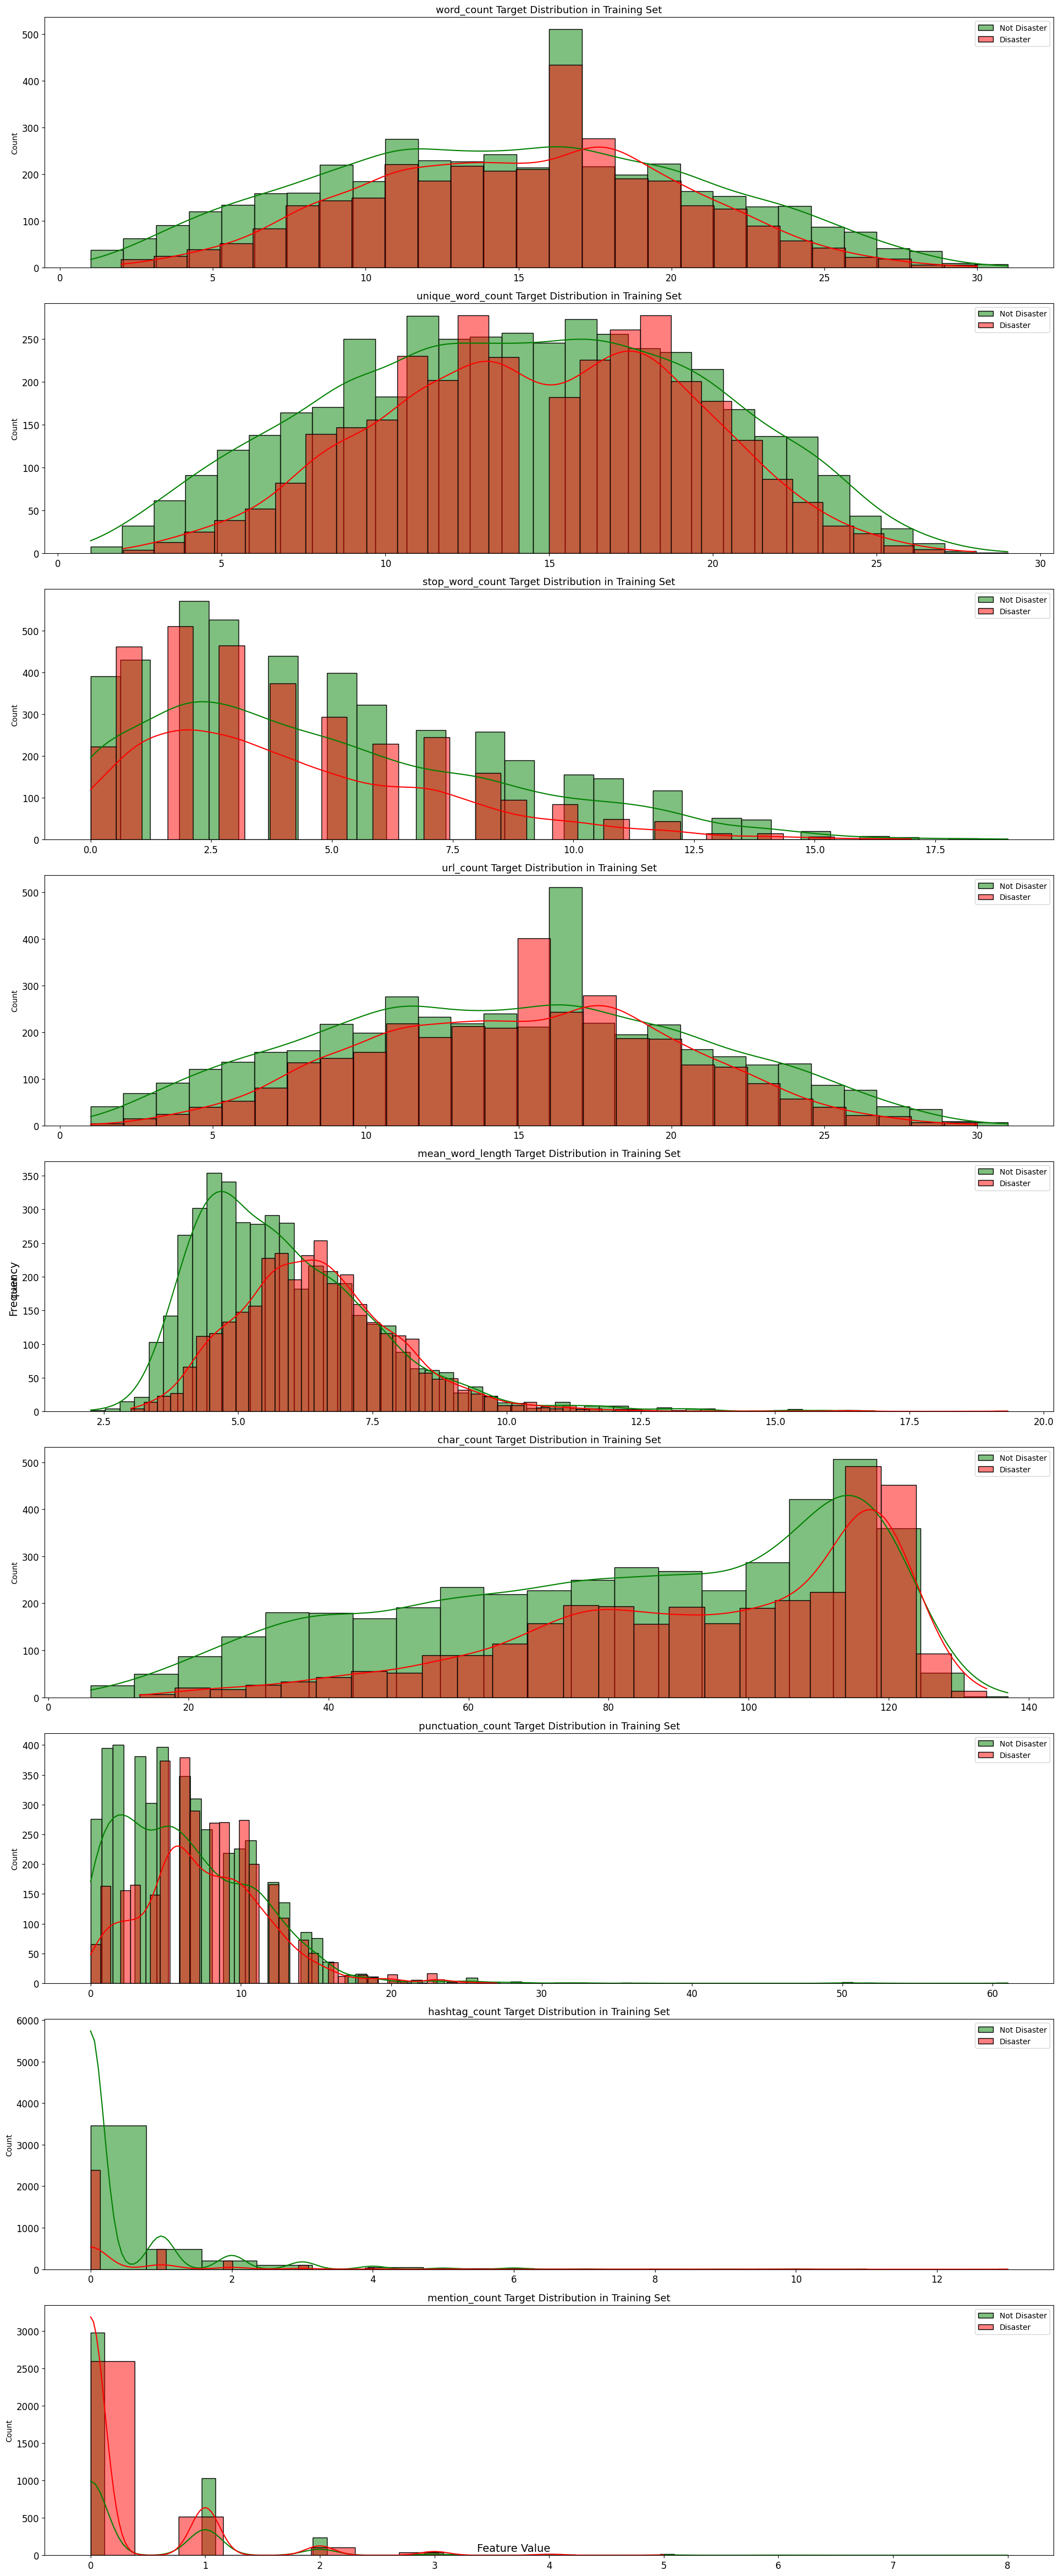

In [16]:
METAFEATURES = ['word_count', 'unique_word_count', 'stop_word_count', 'url_count', 'mean_word_length',
                'char_count', 'punctuation_count', 'hashtag_count', 'mention_count']
DISASTER_TWEETS = train_df['target'] == 1

warnings.filterwarnings('ignore', category=FutureWarning, message="use_inf_as_na option is deprecated and will be removed in a future version.")

fig, axes = plt.subplots(ncols=1, nrows=len(METAFEATURES), figsize=(20, 50), dpi=100)
axes = axes.flatten()

train_df.replace([np.inf, -np.inf], np.nan, inplace=True)
for i, feature in enumerate(METAFEATURES):
    sns.histplot(train_df.loc[~DISASTER_TWEETS][feature], label='Not Disaster', ax=axes[i], color='green', kde=True)
    sns.histplot(train_df.loc[DISASTER_TWEETS][feature], label='Disaster', ax=axes[i], color='red', kde=True)

    axes[i].set_xlabel('')
    axes[i].tick_params(axis='x', labelsize=12)
    axes[i].tick_params(axis='y', labelsize=12)
    axes[i].legend()

    axes[i].set_title(f'{feature} Target Distribution in Training Set', fontsize=13)

fig.text(0.5, 0.04, 'Feature Value', ha='center', fontsize=14)
fig.text(0.04, 0.5, 'Frequency', va='center', rotation='vertical', fontsize=14)

plt.tight_layout(rect=[0.03, 0.03, 1, 0.97])
plt.show()


In [17]:
def create_corpus_target(df, target):
    corpus = []
    for x in (df[df['target']==target]['text'].str.split()):
        for i in x:
            corpus.append(i)
    return corpus

def create_corpus(df):
    corpus = []
    for x in (df['text'].str.split()):
        for i in x:
            corpus.append(i)
    return corpus

corpus_1= create_corpus_target(train_df,1)
corpus_0= create_corpus_target(train_df,0)
corpus = create_corpus(train_df)

### Frequency of Punctuations used in 'Disasters' and 'Not Disaster'

Text(0.5, 1.0, "Frequency of punctuations used for 'Disasters'")

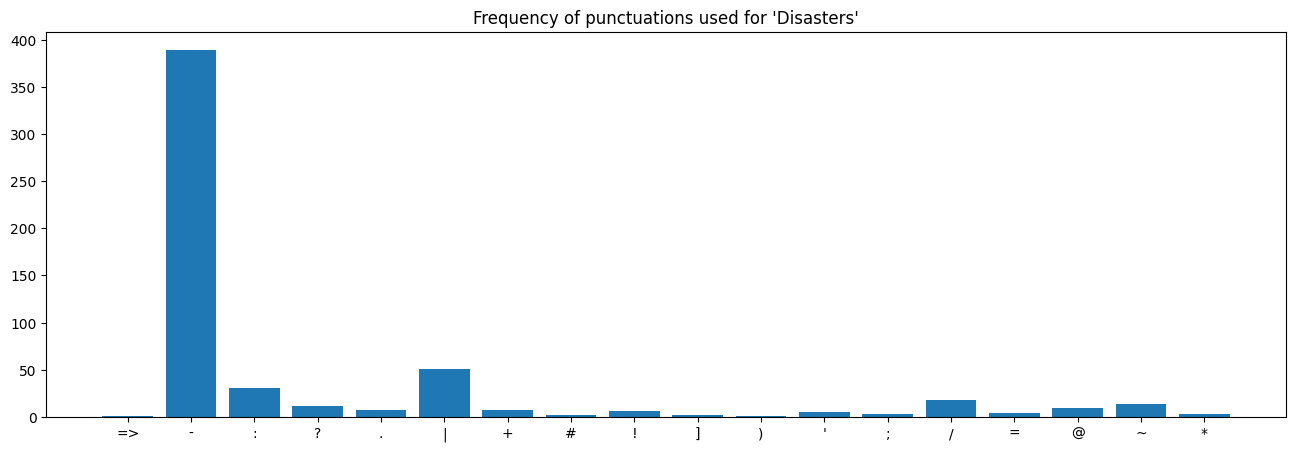

In [18]:
plt.figure(figsize=(16,5))

dic=defaultdict(int)
for i in (corpus_1):
    if i in string.punctuation:
        dic[i]+=1

x,y=zip(*dic.items())
plt.bar(x,y)
plt.title("Frequency of punctuations used for 'Disasters'")

Text(0.5, 1.0, "Frequency of punctuations used for 'Not Disasters'")

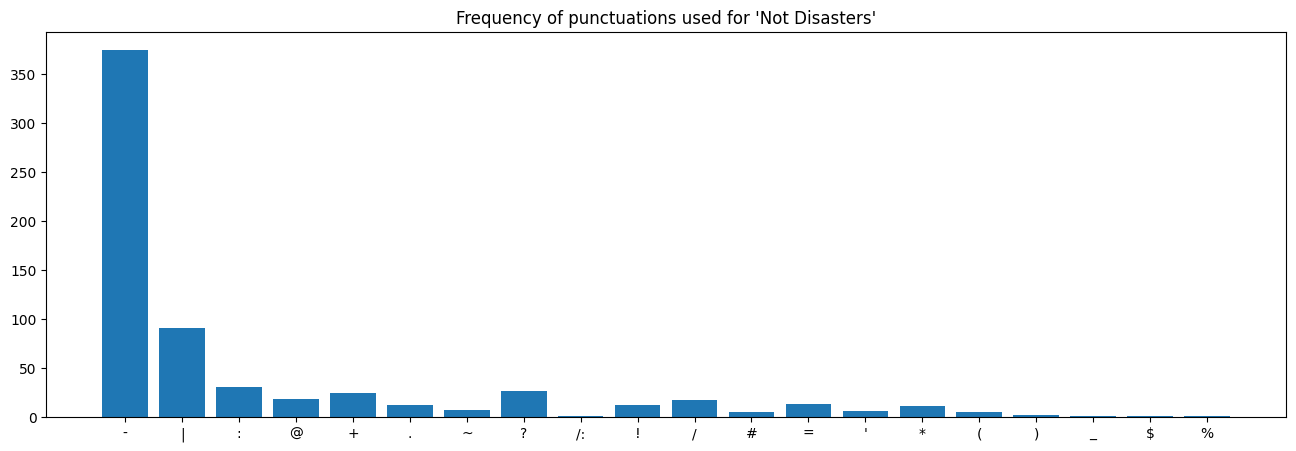

In [19]:
plt.figure(figsize=(16,5))

dic=defaultdict(int)
for i in (corpus_0):
    if i in string.punctuation:
        dic[i]+=1

x,y=zip(*dic.items())
plt.bar(x,y)
plt.title("Frequency of punctuations used for 'Not Disasters'")

### Frequency of Unique Words

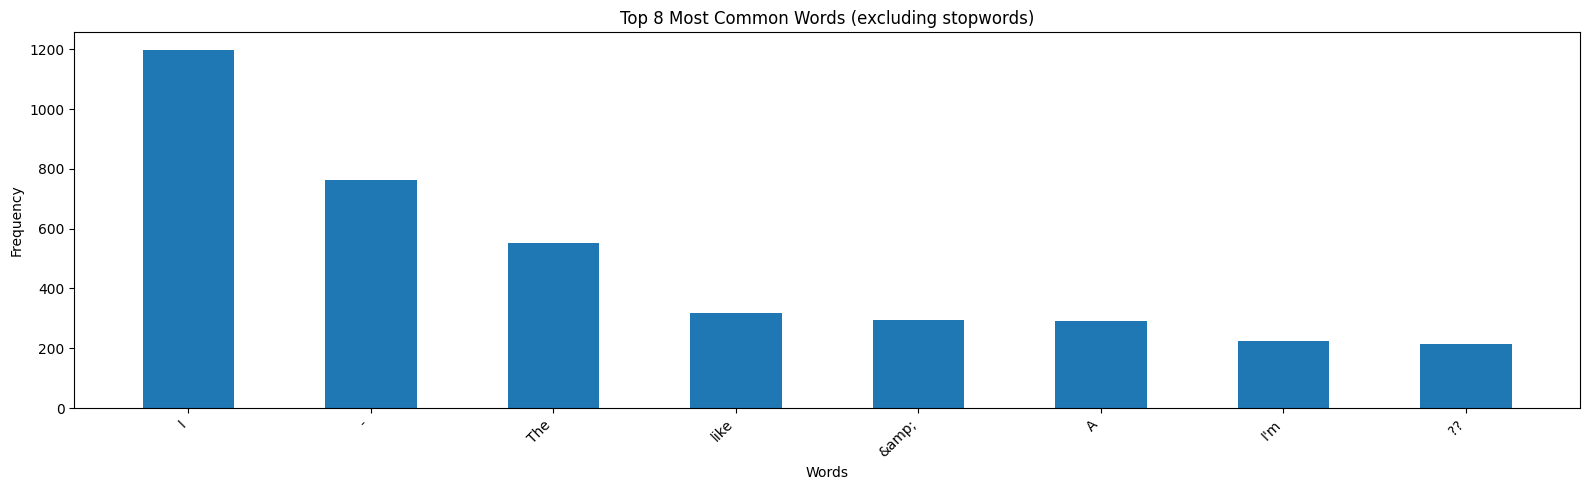

In [20]:
plt.figure(figsize=(16,5))
counter=Counter(corpus)
most=counter.most_common()
x=[]
y=[]
for word,count in most[:40]:
    if (word not in stopwords) :
        x.append(word)
        y.append(count)

plt.bar(x, y, width = 0.5)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.title(f'Top {len(x)} Most Common Words (excluding stopwords)')
plt.tight_layout()
plt.show()

Above plot makes it obvious that we need to perform cleaning.

### N-Gram Analysis
We'll do Unigram, Bigram, and Trigram analysis.

In [21]:
def generate_ngram(text,n):
    token = [i for i in text.lower().split(' ') if i != '' if i not in stopwords]
    ngrams = zip(*[token[i:] for i in range(n)])
    return [' '.join(ngram) for ngram in ngrams]

In [22]:
unigram = []
for text in train_df['text']:
    for i in generate_ngram(text,1):
        unigram.append(i)
bigram = []
for text in train_df['text']:
    for i in generate_ngram(text,2):
        bigram.append(i)
trigram = []
for text in train_df['text']:
    for i in generate_ngram(text,3):
        trigram.append(i)

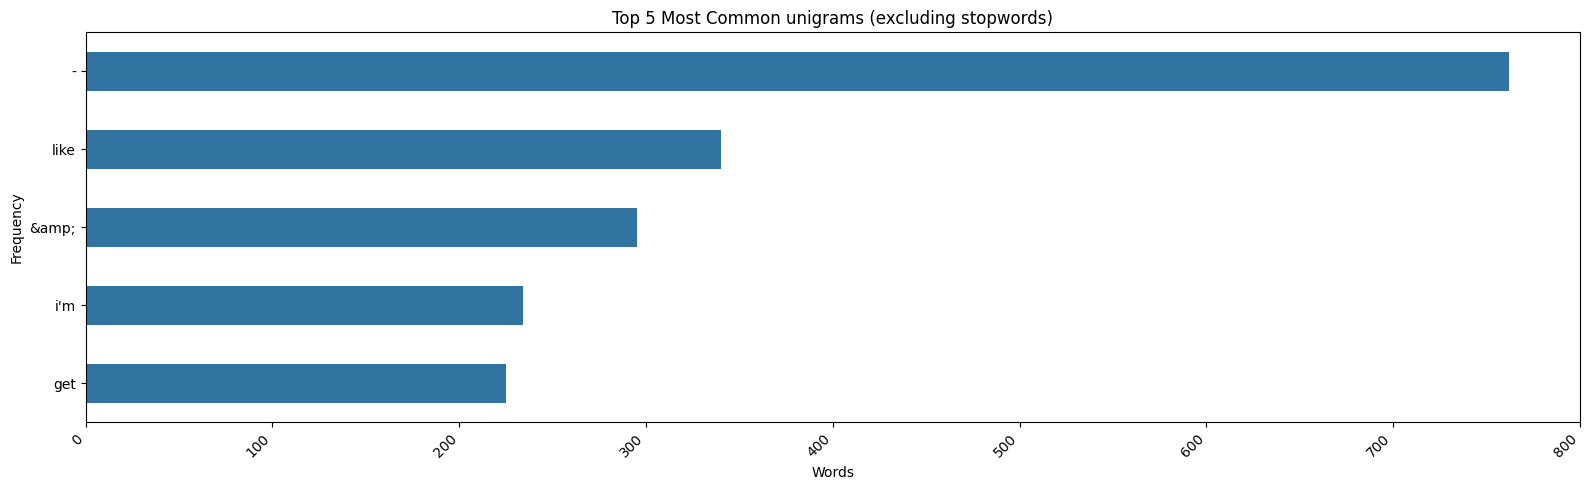

In [23]:
plt.figure(figsize=(16,5))
counter=Counter(unigram)
most=counter.most_common()
x=[]
y=[]
for word,count in most[:5]:
    x.append(word)
    y.append(count)

sns.barplot(x=y, y=x, width = 0.5)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.title(f'Top {len(x)} Most Common unigrams (excluding stopwords)')
plt.tight_layout()
plt.show()

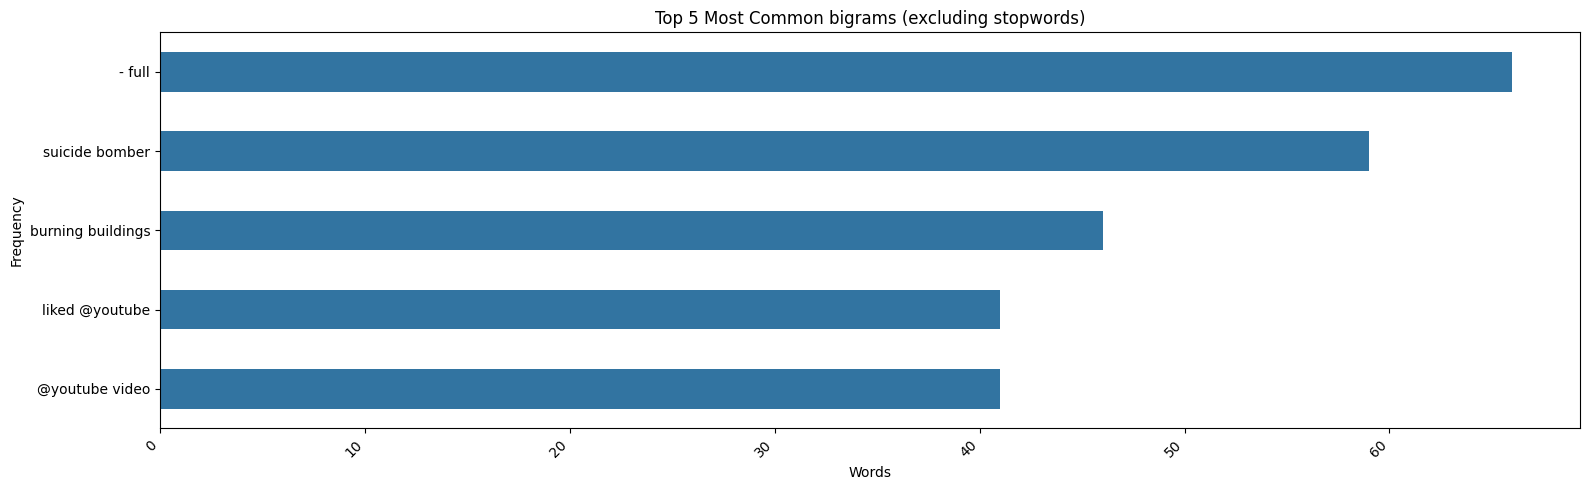

In [24]:
plt.figure(figsize=(16,5))
counter=Counter(bigram)
most=counter.most_common()
x=[]
y=[]
for word,count in most[:5]:
    x.append(word)
    y.append(count)

sns.barplot(x=y, y=x, width = 0.5)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.title(f'Top {len(x)} Most Common bigrams (excluding stopwords)')
plt.tight_layout()
plt.show()

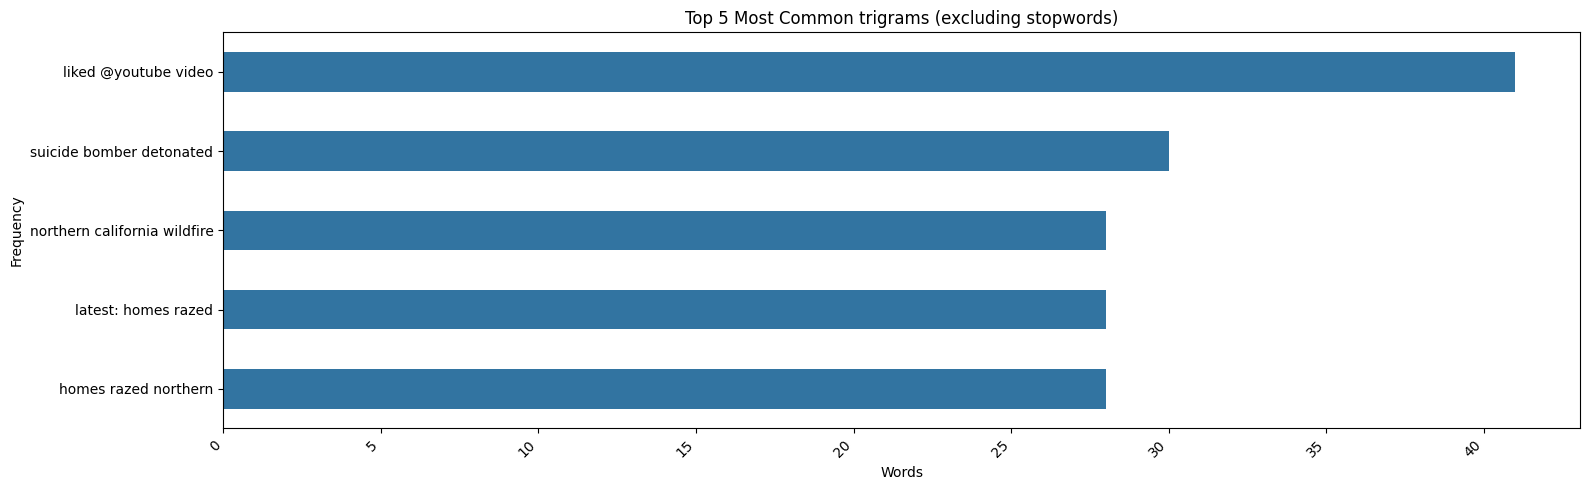

In [25]:
plt.figure(figsize=(16,5))
counter=Counter(trigram)
most=counter.most_common()
x=[]
y=[]
for word,count in most[:5]:
    x.append(word)
    y.append(count)

sns.barplot(x=y, y=x, width = 0.5)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.title(f'Top {len(x)} Most Common trigrams (excluding stopwords)')
plt.tight_layout()
plt.show()

# Data Cleaning

In [26]:
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)

def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def remove_punct(text):
    table=str.maketrans('','',string.punctuation)
    return text.translate(table)

def remove_special_characters(text):
    text = re.sub(r'[^\w\s]', '', text)
    return text

def remove_unnecessary_spaces(text):
    text = text.strip()
    text = re.sub(r'\s+', ' ', text)
    return text

def make_text_lower(text):
    text = text.lower()
    return text

def remove_stopwords(text):
    text = [i for i in text.split() if i not in stopwords]
    return ' '.join(text)

In [27]:
train_df['text'] = train_df['text'].apply(lambda x : remove_punct(x))

train_df['text'] = train_df['text'].apply(lambda x : remove_emoji(x))

train_df['text'] = train_df['text'].apply(lambda x : remove_html(x))

train_df['text'] = train_df['text'].apply(lambda x : remove_URL(x))

train_df['text'] = train_df['text'].apply(lambda x : remove_special_characters(x))

train_df['text'] = train_df['text'].apply(lambda x : remove_unnecessary_spaces(x))

train_df['text'] = train_df['text'].apply(lambda x : make_text_lower(x))

# train_df['text'] = train_df['text'].apply(lambda x : remove_stopwords(x))

It was observed that removing stopwords led to loss of accuracy in validation set. It is due to loss of context after the removal of stopwords. Hence, I do not perform

In [28]:
train_df['text'].head()

0    our deeds are the reason of this earthquake ma...
1                forest fire near la ronge sask canada
2    all residents asked to shelter in place are be...
3    13000 people receive wildfires evacuation orde...
4    just got sent this photo from ruby alaska as s...
Name: text, dtype: object

# Model

In [29]:
!pip install --upgrade keras-nlp
!pip install --upgrade keras
!pip install keras-core --upgrade


# This sample uses Keras Core, the multi-backend version of Keras.
# The selected backend is TensorFlow (other supported backends are 'jax' and 'torch')
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 571.8/571.8 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 21.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 MB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 103.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 102.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 105.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 81.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 45.5 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.2.0
    Uninstalling ml-dtypes-0.2.0:
      Successfully uninstalled ml-dtypes-0.2.0
  Attempting uninstall: h5py
    Found existing installation: h5py 3.9.0
    Uninstalling h5py-3.9.0:
      Successfully uninstalled h5py-3.9.0
  Attempting uninstall: tensorboard
    Found e

In [30]:
# import tensorflow as tf
# import keras_core as keras
# import keras_nlp
# from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix


import warnings
warnings.filterwarnings("ignore", message="`Model.state_updates`", category=UserWarning)
warnings.filterwarnings("ignore", message="`layer.updates`", category=UserWarning)
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import keras_core as keras
import keras_nlp
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import classification_report

print("TensorFlow version:", tf.__version__)
print("Keras Core version:", keras.__version__)
print("Keras NLP version:", keras_nlp.__version__)

Using TensorFlow backend
TensorFlow version: 2.16.2
Keras Core version: 0.1.7
Keras NLP version: 0.14.0


In [31]:
BATCH_SIZE = 32
NUM_TRAINING_EXAMPLES = train_df.shape[0]
TRAIN_SPLIT = 0.8
VAL_SPLIT = 0.2
STEPS_PER_EPOCH = int(NUM_TRAINING_EXAMPLES)*TRAIN_SPLIT // BATCH_SIZE

EPOCHS = 2
AUTO = tf.data.experimental.AUTOTUNE

## Preparing The Data

In [33]:
from sklearn.model_selection import train_test_split

X = train_df["text"]
y = train_df["target"]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=VAL_SPLIT, random_state=42)

In [34]:
# Load a DistilBERT model.
preset= "distil_bert_base_en_uncased"

# Use a shorter sequence length.
preprocessor = keras_nlp.models.DistilBertPreprocessor.from_preset(preset,
                                                                   sequence_length=160,
                                                                   name="preprocessor_4_tweets"
                                                                  )

# Pretrained classifier.
classifier = keras_nlp.models.DistilBertClassifier.from_preset(preset,
                                                               preprocessor = preprocessor,
                                                               num_classes=2)

classifier.summary()

100%|██████████| 580/580 [00:00<00:00, 399kB/s]
100%|██████████| 226k/226k [00:00<00:00, 1.21MB/s]
100%|██████████| 515/515 [00:00<00:00, 333kB/s]
100%|██████████| 253M/253M [00:07<00:00, 34.9MB/s]


Preprocessor: "preprocessor_4_tweets"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Tokenizer (type)                                   ┃                                             Vocab # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ distil_bert_tokenizer (DistilBertTokenizer)        │                                              30,522 │
└────────────────────────────────────────────────────┴─────────────────────────────────────────────────────┘

Model: "distil_bert_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ distil_bert_backbone          │ (None, None, 768)         │      66,362,880 │ padding_mask[0][0],        │
│ (DistilBertBackbone)          │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ get_item (GetItem)            │ (None, 768)               │               0 │ distil_bert_backbone[0][0] │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pooled_dense (Dense)          │ (None, 768)               │         590,592 │ get_item[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ output_dropout (Dropout)      │ (None, 768)               │               0 │ pooled_dense[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ logits (Dense)                │ (None, 2)                 │           1,538 │ output_dropout[0][0]       │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 66,955,010 (255.41 MB)

 Trainable params: 66,955,010 (255.41 MB)

 Non-trainable params: 0 (0.00 B)

In [35]:
# Ensure consistent import of Keras modules
from keras.losses import SparseCategoricalCrossentropy
from keras.optimizers import Adam

# Compile the model
classifier.compile(
    loss=SparseCategoricalCrossentropy(from_logits=True),
    optimizer=Adam(1e-5),
    metrics=["accuracy"]
)


# Fit
history = classifier.fit(x=X_train,
                         y=y_train,
                         batch_size=BATCH_SIZE,
                         epochs=EPOCHS,
                         validation_data=(X_val, y_val)
                        )

Epoch 1/2
191/191 ━━━━━━━━━━━━━━━━━━━━ 239s 813ms/step - accuracy: 0.7430 - loss: 0.5611 - val_accuracy: 0.8385 - val_loss: 0.3967
Epoch 2/2
191/191 ━━━━━━━━━━━━━━━━━━━━ 113s 592ms/step - accuracy: 0.8453 - loss: 0.3775 - val_accuracy: 0.8398 - val_loss: 0.3866


In [36]:
def displayConfusionMatrix(y_true, y_pred, dataset):
    disp = ConfusionMatrixDisplay.from_predictions(
        y_true,
        np.argmax(y_pred, axis=1),
        display_labels=["Not Disaster","Disaster"],
        cmap=plt.cm.Blues
    )

    tn, fp, fn, tp = confusion_matrix(y_true, np.argmax(y_pred, axis=1)).ravel()
    f1_score = tp / (tp+((fn+fp)/2))

    disp.ax_.set_title("Confusion Matrix on " + dataset + " Dataset -- F1 Score: " + str(f1_score.round(2)))

191/191 ━━━━━━━━━━━━━━━━━━━━ 33s 164ms/step


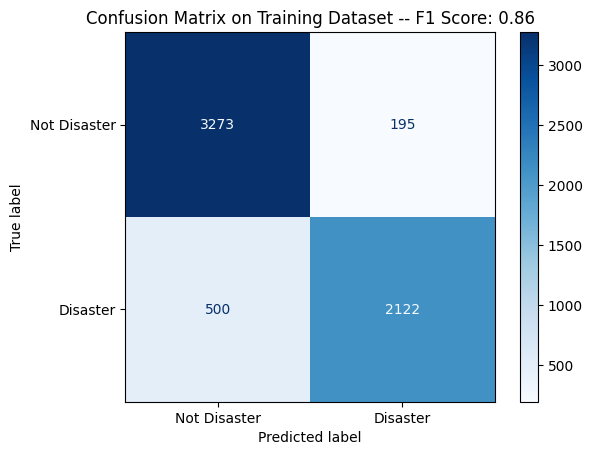

In [37]:
y_pred_train = classifier.predict(X_train)

displayConfusionMatrix(y_train, y_pred_train, "Training")

In [38]:
print (classification_report(y_train, np.argmax(y_pred_train, axis=1)))

              precision    recall  f1-score   support

           0       0.87      0.94      0.90      3468
           1       0.92      0.81      0.86      2622

    accuracy                           0.89      6090
   macro avg       0.89      0.88      0.88      6090
weighted avg       0.89      0.89      0.88      6090



48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 164ms/step


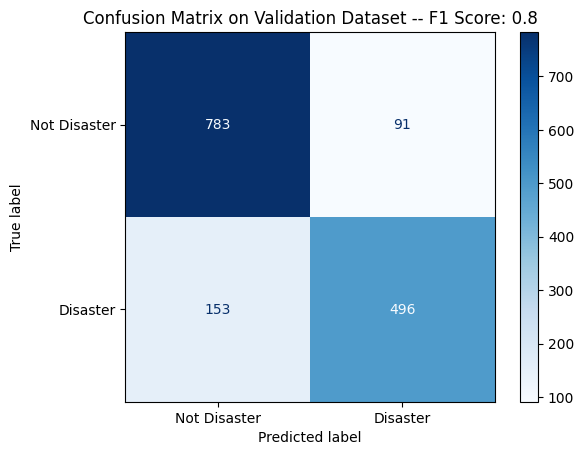

In [39]:
y_pred_val = classifier.predict(X_val)

displayConfusionMatrix(y_val, y_pred_val, "Validation")

In [40]:
print (classification_report(y_val, np.argmax(y_pred_val, axis=1)))

              precision    recall  f1-score   support

           0       0.84      0.90      0.87       874
           1       0.84      0.76      0.80       649

    accuracy                           0.84      1523
   macro avg       0.84      0.83      0.83      1523
weighted avg       0.84      0.84      0.84      1523

